In [ ]:
import numpy as np;
import pandas as pd;

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer,roc_auc_score,precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
!pip install --upgrade scikit-learn
roc_auc_scoreScorer=make_scorer(roc_auc_score)
mccScorer = make_scorer(matthews_corrcoef)
from numpy import mean
from numpy import std

from google.colab import drive
drive.mount("/content/gdrive")

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_validate

Mounted at /content/gdrive


In [ ]:
#read training dataset 1
data1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_1_Training.csv')

X_train_actual_1=data1[:-2].T[1:].values

y_train_actual_1 = data1[-2:].T[-130:].T.values

In [ ]:
#read training dataset 2
data2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_2_Training.csv')

X_train_actual_2=data2[:-4].T[1:].values

y_train_actual_2 = data2[-4:].T[-340:].T.values

In [ ]:
co1={'X':X_train_actual_1,'Y': y_train_actual_1[0]};
co2={'X':X_train_actual_1,'Y': y_train_actual_1[1]};

co3={'X':X_train_actual_2,'Y': y_train_actual_2[0]};
co4={'X':X_train_actual_2,'Y': y_train_actual_2[1]};
co5={'X':X_train_actual_2,'Y': y_train_actual_2[2]};
co6={'X':X_train_actual_2,'Y': y_train_actual_2[3]};

In [ ]:
def RandomForest_HP_Tuning(X,Y):
  n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

  #max_depth = [int(x) for x in np.linspace(start=10, stop=X.shape[1], num = 50)]

  #max_features = [int(x) for x in np.linspace(start = 5 , stop = X.shape[1], num = 50)]
  max_features = ['log2', 'sqrt']

  min_samples_split = [2, 5, 10]

  min_samples_leaf = [1, 2, 4]
  rf_grid = {'n_estimators': n_estimators,
            'max_features': max_features,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf}
  search = GridSearchCV(RandomForestClassifier(class_weight='balanced',random_state=1), rf_grid, scoring = mccScorer, cv = 2,verbose=2)
  # fit the model
  search.fit(X, Y.astype('int'))
    # summarize result
  print('Best Score: %s' % search.best_score_)
  print('Best Hyperparameters: %s' % search.best_params_)

In [ ]:
# Hyper parameter tuning for random forest
def find_best_HP_for_RandForest():
  print("RF-tuning-CO1 started")
  RandomForest_HP_Tuning(**co1);
  print("RF-tuning-CO2 started")
  RandomForest_HP_Tuning(**co2);
  print("RF-tuning-CO3 started")
  RandomForest_HP_Tuning(**co3);
  print("RF-tuning-CO4 started")
  RandomForest_HP_Tuning(**co4);
  print("RF-tuning-CO5 started")
  RandomForest_HP_Tuning(**co5);
  print("RF-tuning-CO6 started")
  RandomForest_HP_Tuning(**co6);

In [ ]:
#RandomForest_HP_Tuning(**co4);

In [ ]:
def determine_number_of_top_features(X,Y):
  X=pd.DataFrame(X)
  X=X.astype(float)

  Y=pd.DataFrame(Y)
  Y=Y.astype(int)

  sel = f_classif(X, Y)
  p_values = pd.Series(sel[1])
  p_values.index = X.columns
  p_values.sort_values(ascending=True, inplace=True)
  p_values = p_values[p_values < 0.05]
  X_p = X[p_values.index]
  return X_p.shape[1]

In [ ]:
best_co1=determine_number_of_top_features(**co1)
best_co2=determine_number_of_top_features(**co2)
best_co3=determine_number_of_top_features(**co3)
best_co4=determine_number_of_top_features(**co4)
best_co5=determine_number_of_top_features(**co5)
best_co6=determine_number_of_top_features(**co6)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
def feature_selector(X,Y,numberOfFeaturesToBeSelected=1):
  if(numberOfFeaturesToBeSelected == 1):
    totalNumberOfFeatures=X.shape[1]
    numberOfFeaturesToBeSelected=totalNumberOfFeatures//2;
  # define feature selection
  fs = SelectKBest(score_func=f_classif, k=numberOfFeaturesToBeSelected)
  # apply feature selection
  return fs.fit(X, Y)

In [ ]:
def plot_PRC_for_CV(predictor,k_fold,X,y,label):
  f, axes = plt.subplots(1,1,squeeze=False)
  
  y_real = []
  y_proba = []
  
  for i, (train_index, test_index) in enumerate(k_fold.split(X,y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes[0,0].step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

  y_real = np.concatenate(y_real)
  y_proba = np.concatenate(y_proba)
  precision, recall, _ = precision_recall_curve(y_real, y_proba)
  lab = 'Overall AUC=%.4f' % (auc(recall, precision))
  axes[0,0].step(recall, precision, label=lab, lw=2, color='black')
  axes[0,0].set_xlabel('Recall')
  axes[0,0].set_ylabel('Precision')
  axes[0,0].legend(loc='lower left', fontsize='small')
  axes[0,0].set(title=label)

  # f.tight_layout()
  f.savefig(label+'.png')

In [ ]:
def plot_ROC_for_CV(classifier,cv,X,y,label):
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = RocCurveDisplay.from_estimator(
          classifier,
          X[test],
          y[test],
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      title=label,
  )
  ax.legend(loc="lower right")
  plt.show()
  fig.savefig(label+'.png')

In [ ]:
def RandomForest_with_cross_validation(X,Y,n_estimators,endpointLabel,numberOfFeatures=1):
  X_selected_features=feature_selector(X,Y,numberOfFeaturesToBeSelected=numberOfFeatures).transform(X);
  
  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1','ruc_auc':roc_auc_scoreScorer}
  
  # define model
  model = RandomForestClassifier(n_estimators=n_estimators,random_state=1,max_depth=5,max_features=(X_selected_features.shape[1]//2))
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print(model.get_params())
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-RF-DTbase-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-RF-DTBase-'+endpointLabel)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 1961, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.319 SD: (0.061)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [17.08321075  0.05960107  0.31914173  0.76923077  0.57333333  0.36190476
  0.44161616  0.63437343]
SD [0.27627253 0.00455578 0.06102058 0.02432521 0.06463573 0.05714286
 0.05410748 0.02758343]


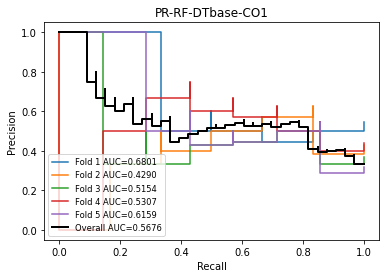

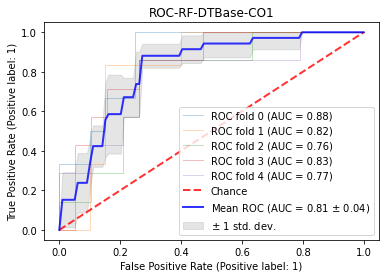

In [ ]:
RandomForest_with_cross_validation(co1['X'],co1['Y'],500,'CO1',best_co1)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.446 SD: (0.040)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.25534086 0.01789613 0.4456103  0.80769231 0.85333333 0.33809524
 0.46464646 0.65404762]
SD [0.00721023 0.00165006 0.04049539 0.         0.18086213 0.08302665
 0.04040404 0.02298082]


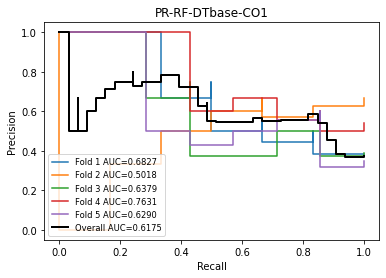

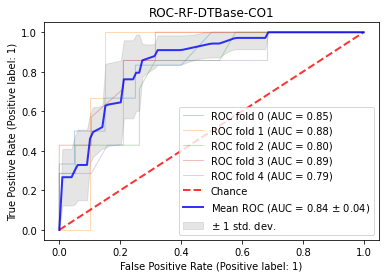

In [ ]:
RandomForest_with_cross_validation(co1['X'],co1['Y'],100,'CO1',best_co1)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 1367, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 800, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.543 SD: (0.158)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [19.79701881  0.09388618  0.54263289  0.76923077  0.74798535  0.7
  0.69804009  0.76      ]
SD [0.36597509 0.00753502 0.15818866 0.06435846 0.13406073 0.21172257
 0.10868738 0.08107887]


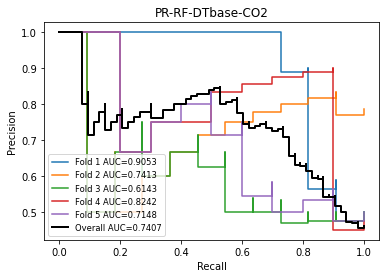

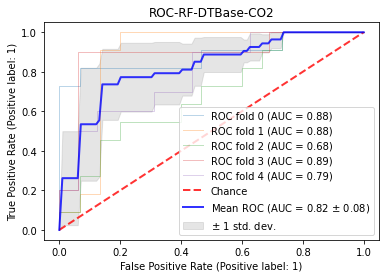

In [ ]:
RandomForest_with_cross_validation(co2['X'],co2['Y'],800,'CO2',best_co2)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 4803, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.297 SD: (0.046)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [1.57549774e+02 7.71678448e-02 2.97180072e-01 7.85294118e-01
 7.59523810e-01 1.91911765e-01 2.97109077e-01 5.84266591e-01]
SD [1.02695298 0.01278066 0.04608041 0.00720438 0.12426656 0.06684305
 0.0798345  0.02715427]


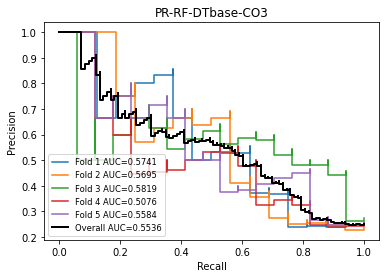

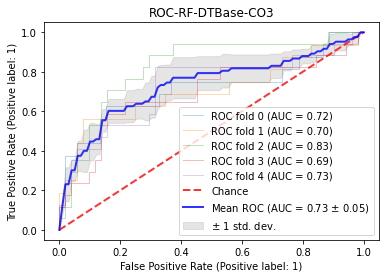

In [ ]:
RandomForest_with_cross_validation(co3['X'],co3['Y'],400,'CO3',best_co3)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 3386, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 800, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.177 SD: (0.144)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [2.32089489e+02 1.10036564e-01 1.76533790e-01 8.58823529e-01
 6.00000000e-01 6.00000000e-02 1.09090909e-01 5.30000000e-01]
SD [0.94008171 0.00332859 0.14413924 0.01176471 0.48989795 0.04898979
 0.08907235 0.0244949 ]


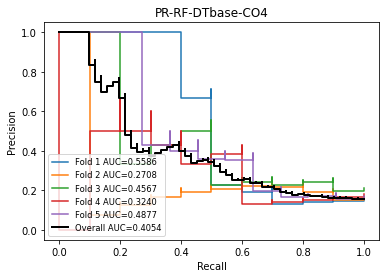

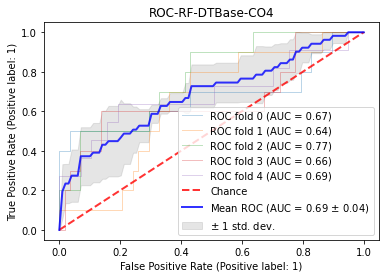

In [ ]:
RandomForest_with_cross_validation(co4['X'],co4['Y'],800,'CO4',best_co4)

In [ ]:
RandomForest_with_cross_validation(co6['X'],co6['Y'],800,'CO6',best_co6)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 800, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
MCC Score- Mean: 0.274 SD: (0.123)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [5.7645443  0.10314193 0.27435118 0.66176471 0.66077401 0.88
 0.7539071  0.615     ]
SD [0.04352199 0.00237239 0.1234034  0.0492153  0.03706209 0.0484768
 0.0333929  0.05538133]


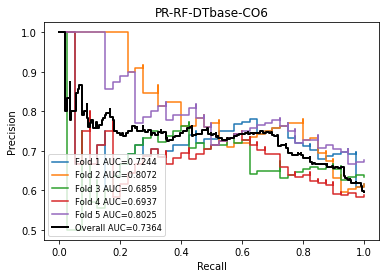

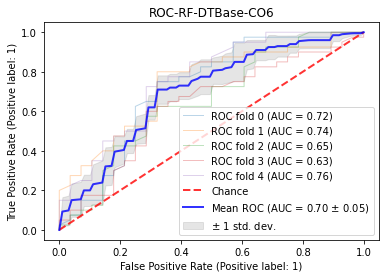

In [ ]:
RandomForest_with_cross_validation(co6['X'],co6['Y'],800,'CO6',best_co6)